# Aiyagari Model with Aggregate Uncertainty

## Introduction

The Aiyagari model is the workhorse of modern macroeconomics. [Contribution of Bewley-...]
Because of a borrowing constraint, agents use a safe-asset to self-insure. Richer fluctuations and properties. The original model abstracts from aggregate fluctuations. Nowadays, there exists many methods to simulate out-of-steady-state dynamics for models of this class. 

In this notebook, I would like to present a methodology that is quite general and easy to follow. It is a **3-step procedure**, which proceeds as follows:

1. Solve for the non-stochastic steady-state
2. Perturbe the model around its non-stochastic steady-state
3. Use the perturbation to calculate out-of-steady-state dynamics 

I use the BKM and GenBKM algorithms for step 2 and 3, which means that the only theoretical tool needed is **backward induction** (i.e. knowing the value tomorrow, what is the value today?).

What are the cons of the methodology presented here? First, the methodology assumes a small aggregate shock. The idea is that if the economy is hit a by a small aggregate shock, then the economy enventually goes back to its steady-state value. If the shock is large, the value of steady-state may be altered and the methodology presented here is not adequate. An example of a large shock could be the disruption caused by COVID-19. If the virus disappears tomorrow, will the economy converge back to its previous steady-state, or should we expect it to converge toward a new steady-state? I am tempted to vote for the second option.

This methodology also fails when the non-stochastic steady-state is not relevant for the dynamic economy. See the [...] 

On the pros side, the methodology presented in this notebook is fast (orders of magnitude faster than Krusell-Smith) and transparent.

## I. The Model



## II. Methodology

## II. Implementation

### II. A Dependencies

In [1]:
using Distributions
using Plots
using DataFrames
using Random
using ForwardDiff
using LinearAlgebra
using Interpolations
using DataFrames
using Optim
using IterativeSolvers
#plotlyjs()
Random.seed!(1234);

In [2]:
using NBInclude #To load stuct and functions from notebooks

In [3]:
@nbinclude("utils.ipynb") #mutable structs and primitive functions for the model
@nbinclude("RBC.ipynb")   #RBC model
@nbinclude("EGM.ipynb")   #implementation of the EGM method
@nbinclude("SteadyState.ipynb") #to calculate the non-stochastic steady-state
@nbinclude("GenBKM.ipynb") #to simulate the stochastic model using the GenBKM algorithm

Steady state: [1.0, 1.0204081632653061, 45.63711005516377, 4.610279485164506, 3.697537284061231]Epsilon state: [0.0]Convergence flag = 1

GenBKM_path! (generic function with 1 method)

### II.B Steady-state

#### Find the steady-state value of capital

In [4]:
p = Params() #struct with parameters
z_ss = 1.0 #aggregate productivity at the non-stochastic steady-state
@time oo = optimize(K -> eq_K(K,p), 10, 100, Brent()) #solve for the steady-state value of capital using Brent method
K_star = oo.minimizer;
println("Steady-state value of capital K* = $(K_star)")
# Store the optimal policy function at the steady-state
g_star, c_star, g_low_star, g_high_star, success_flag= solve_EGM(x->log(x), x->log(x), R(K_star, z_ss, p), W(K_star, z_ss, p), p); #solve for policy functions
# Store the stationary distribution at the steady-state
t_star = make_trans_mat(g_star, p)    #generate transition matrix
d_star = get_stationary_dist(t_star); #stationary distribution

  7.703330 seconds (8.16 M allocations: 1.703 GiB, 3.88% gc time)
Steady-state value of capital K* = 46.81669973104484


#### Visualize transition probabilities

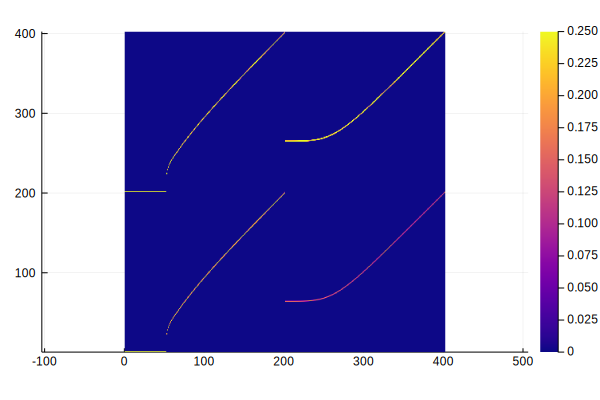

In [5]:
xs = [string("x", i) for i = 1:size(t_star,1)]
ys = [string("y", i) for i = 1:size(t_star,2)]
heatmap(t_star, aspect_ratio = 1, color=:plasma, clim=(0., 0.25))

*Notes: This graph shows the transition probabilities across capital and idiosyncratic probability states.*

#### Visualize convergence toward the steady-state

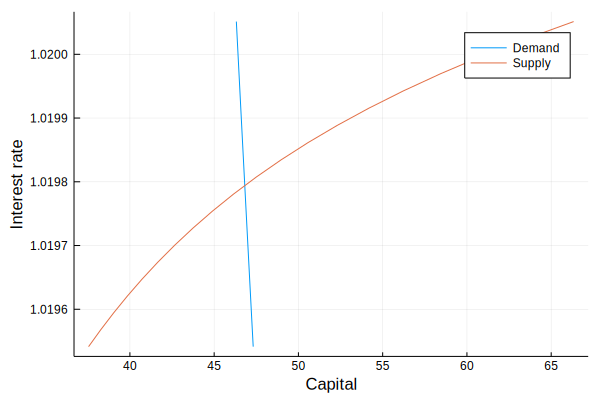

In [6]:
# Solve for the demand and supply of capital for different values of the interest rate
K_grid = collect(range(oo.minimizer-0.5, stop=oo.minimizer+0.5, length=20))
K_implied_grid = similar(K_grid)
R_grid = similar(K_grid)

for (K_index, K_value) in enumerate(K_grid)
    R_s, W_s = R(K_value, z_ss, p), W(K_value, z_ss, p) #calculate interest rate R and wage W
    gg, c_star, g_low, g_high, success_flag= solve_EGM(x -> log(x), x -> 2*log(x), R_s, W_s, p) #solve for policy functions
    tt = make_trans_mat(gg, p)   #generate transition matrix
    dd = get_stationary_dist(tt) #stationary distribution
    K_implied = aggregate_K(dd, p) #implied level of capital
    R_grid[K_index] = R_s #store interest rate
    K_implied_grid[K_index] = K_implied #store demand of capital
    K_grid[K_index] = K_value #store supply of capital
end

# Plot demand and supply of capital
plot(K_grid, R_grid, label = "Demand", ylabel="Interest rate", xlabel="Capital")
plot!(K_implied_grid, R_grid, label = "Supply")

*Notes: This graph shows the demand and the supply of capital as a function of the interest rate.*

### II.C MIT Shock

#### Backward and forward updates

In [7]:
function backward_update(g_low_ss::Function, g_high_ss::Function, K_path_guess::Array{Float64,1}, z_path::Array{Float64,1}, p::Params)
    """
    Update policy functions backward, holding {K_t,z_t} constant
    [TODO] Should be a function that updates: a_path, R_path, W_path, g_low_path, g_high_path
    """
    nT = length(z_path)
    g_low_path = Array{Function}(undef,nT) #initialize two lists of functions
    g_high_path =  Array{Function}(undef,nT)
    g_low_path[nT] = g_low_ss
    g_high_path[nT] = g_high_ss
    a_path = zeros(p.nI, p.grid_size, nT) #to store policy functions on savings grid
    R_path = zeros(nT) #to store the interest rate on path
    W_path = zeros(nT) #to store the wage on path
    
    #Start from the steady-state and iterate backward
    #holding constant the path for {K_t,z_t}
    #---------------------------------------------------
    for t=nT:-1:2 #iterate backward
        # Next period
        R_path[t], W_path[t] = R(K_path_guess[t], z_path[t], p), W(K_path_guess[t], z_path[t], p)
        # Current period
        R_path[t-1], W_path[t-1] = R(K_path_guess[t-1], z_path[t-1], p), W(K_path_guess[t-1], z_path[t-1], p)
        # Current period's policy, given next period
        a_path[:,:,t-1], c_new, g_low_path[t-1], g_high_path[t-1] = euler_back(g_low_path[t], g_high_path[t], R_path[t-1], W_path[t-1], R_path[t], W_path[t], p)
    end
    
    return a_path, g_low_path, g_high_path
end

function forward_update(K_star::Float64, a_path::Array{Float64,3}, d_ss::Array{Float64,1}, p::Params)
    """
    Update forward the distribution of agents + aggregate capital
    [TODO]: should be a function that updates:
    dd_path_forward, K_path_forward
    """
    nT = length(z_path)
    K_path_forward = zeros(nT)
    K_path_forward[1] = K_star
    dd_path_forward = zeros(size(d_ss,1), nT)
    dd_path_forward[:,1] = d_ss
    #2. Iterate forward {K_t,z_t}, using the policy
    #functions from step 1
    #-----------------------------------------------
    for t=2:nT
        tt = make_trans_mat(a_path[:,:,t-1], p) #generate transition matrix
        dd_path_forward[:,t] = tt*dd_path_forward[:,t-1]
        K_path_forward[t] = aggregate_K(dd_path_forward[:,t], p)
    end
    
    return dd_path_forward, K_path_forward
end

forward_update (generic function with 1 method)

#### Finding the transition path

In [8]:
function solve_mit!(K_path, g_low_ss::Function, g_high_ss::Function, d_ss::Array{Float64,1}, 
                    K_ss::Float64, z_path::Array{Float64,1}, p::Params; convex_combination::Float64 = 0.2,
                    shrink_factor::Float64 = 0.5, expand_factor::Float64 = 1.05,
                    max_iter::Int64 = 1000, tol::Float64=1e-6, verbose::Bool=true, display_iter::Int64 = 20)
    """
    Finds K_path
    """
    diff = Inf #initialization
    diff_old = Inf #initialization
    convergence_flag = 0 #initialization
    damp = convex_combination #initial dampening parameter
    
    for i_mit=1:max_iter
    
        # Step 1. Solve backward the policy functions {g_t(a,e_low), g_t(a,e_high)}, keeping {K_t,z_t} constant:
        a_path, g_low_path, g_high_path = backward_update(g_low_ss, g_high_ss, K_path[i_mit], z_path, p);
        
        #2. Solve forward {K_t,z_t}, keeping policy functions {g_t(a,e_low), g_t(a,e_high)} constant:
        dd_path_forward, K_path_forward = forward_update(K_ss, a_path, d_star, p);
        
        # Distance between guess for {K_t} and implied values:
        diff = maximum(abs.(K_path_forward - K_path[i_mit]))
        
        # Display every display_iter iterations
        if verbose==true
            if mod(i_mit,display_iter) == 0
                println("Iteration $(i_mit). diff = $(diff)")
            end
        end

        if diff < tol
            if verbose==true
                println("Convergence reached after $(i_mit) iterations.")
            end
            convergence_flag = 1
            break
        else
            # Update the guess for the path {K_t}
            if diff > diff_old
                # shrink damp and redo with same Xvalue, do not update count
                damp = max(min(damp * shrink_factor, 1.0-eps()), eps())
            else
                damp = max(min(damp * expand_factor, 1.0-eps()), eps())
            end
            if mod(i_mit, 10) == 0
                if verbose==true
                    println("damp = $(damp); diff = $(diff)")
                end
            end
            # Store the updated path for {K_t}
            push!(K_path, damp.*K_path_forward .+ (1.0 - damp).*K_path[i_mit])
            diff_old = diff
                
        end
    end
    
    return K_path, convergence_flag
end

solve_mit! (generic function with 1 method)

#### Find the path for {K_t} for a 1 std. dev positive productivity shock

In [9]:
max_t = 300 #Let us assume that the economy is back to the steady state after max_t periods
z_ss = 1.0  #Value of aggregate productivity at the non-stochastic steady-state
z_shock = 2.0 #Value of the inital shock

# Let's generate a path for the aggregate shock
z_path = ones(max_t)
z_path[1] = z_ss*z_shock #initial shock

# Evolution of aggregate productivity in level:
for t_index=2:max_t 
    z_path[t_index] = z_path[t_index-1]^p.rho 
end

# Heroic guess for the initial path of {K_t}: K_t = K* for all t
K_path = []
push!(K_path, repeat([K_star], max_t))

# Find the path for {K_t}:
@time K_path, convergence_flag = solve_mit!(K_path, g_low_star, g_high_star, d_star, K_star, z_path, p, convex_combination=0.25);

# Find the path for other aggregates:
R_path = zeros(length(z_path)) #to store the interest rate on path
W_path = zeros(length(z_path)) #to store the wage on path
for t=length(z_path):-1:1 #iterate backward
    # Next period
    R_path[t], W_path[t] = R(K_path[end][t], z_path[t], p), W(K_path[end][t], z_path[t], p)
end

damp = 0.19391602699731453; diff = 1.1266234380049411
Iteration 20. diff = 0.027666426981980408
damp = 0.15041370210569288; diff = 0.027666426981980408
damp = 0.24500807115366596; diff = 0.0012299247880207531
Iteration 40. diff = 0.00011995358673289047
damp = 0.19004396696157702; diff = 0.00011995358673289047
damp = 0.1474102841119917; diff = 2.6711131440038116e-6
Convergence reached after 56 iterations.
 12.797912 seconds (9.57 M allocations: 32.818 GiB, 15.70% gc time)


#### Visualize convergence of the transition path

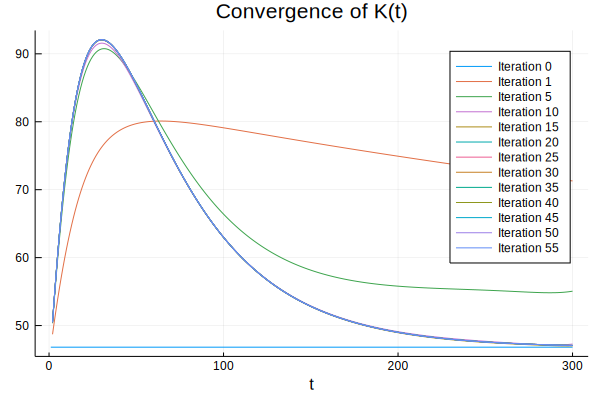

In [10]:
p0 = plot(1:max_t, K_path[1], label= "Iteration 0", title="Convergence of K(t)")
plot!(p0, 2:max_t, K_path[2][2:end], label = "Iteration 1")
show_every = 5 #display {K_t} for each multiple of show_every
for k in 2:length(K_path)
    if mod(k,show_every) == 0
        plot!(p0, 2:max_t, K_path[k][2:end], xlabel="t", label = "Iteration $(k)", title="Convergence of K(t)", legend=:best)
    end
end

p0

*Notes: This graph shows the path for capital {K_t}^(i) for different iterations of the backward-forward algorithm*

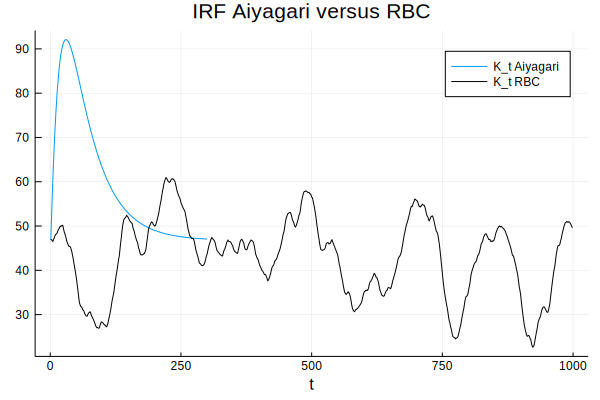

In [11]:
p1 = plot(1:max_t, K_path[end], label= "K_t Aiyagari", title="IRF Aiyagari versus RBC")
plot!(p1, xx[RBCp.iK,2:end] .+ K_star, label = "K_t RBC", color = "black", xlabel="t")

*Notes: This graph shows the impulse reponse of K_t of for the Aiyagari model and a RBC model.*

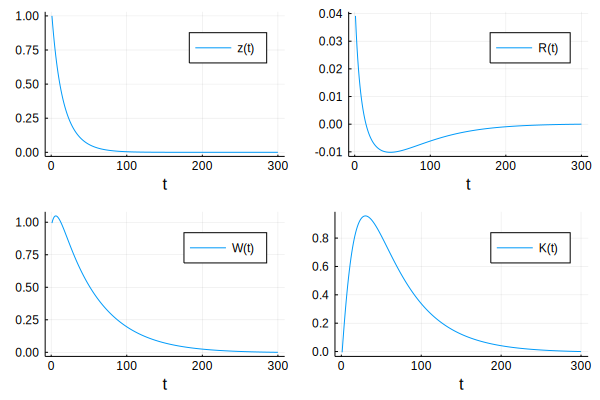

In [12]:
p1 = plot(1:max_t, z_path./z_path[end] .-1, label = "z(t)", xlabel= "t")
p2 = plot(1:max_t, R_path./R_path[end] .-1, label= "R(t)", xlabel= "t")
p3 = plot(1:max_t, W_path./W_path[end].-1 , label= "W(t)", xlabel= "t")
p4 = plot(1:max_t, K_path[end]./K_path[end][end] .-1, label= "K(t)", xlabel= "t" )

p5 = plot(p1, p2, p3, p4)

*Notes: This graph shows the percentage deviation from steady-state values of (i) aggregate productivity (ii) the interest rate (iii) wages (iv) capital.*

#### Linearity checks

To simulate the stochastic economy, the BKM algorithm makes the assumption that an MIT shock is linear with 
respect to the aggregate shock. That is, doubling the initial shock will simply double the value of aggregates
along the transition path, but the shape of transition paths will remain the same. The next block of codes 
calculates several transition paths for different initial aggregate shocks. 

In [13]:
max_t = 300 #Let us assume that the economy is back to the steady state after max_t periods
z_ss = 1.0  #Value of aggregate productivity at the non-stochastic steady-state
# Different initial shocks
array_sigma = collect(range(-0.75, stop=0.75, step=0.25))
# Let's exclude sigma = 0
array_sigma = array_sigma[array_sigma .!= 0.]
# To store the different scaled IRF:
x_mit_scaled_sigma = zeros(max_t, length(array_sigma))
# To store path of aggregate productivity:
z_path_sigma = zeros(max_t, length(array_sigma))
# To store the path for the %deviation of aggregate productivity from its steady-state value
z_path_sigma_dev = zeros(max_t, length(array_sigma))

for (index_sigma, sigma) in enumerate(array_sigma)
    
    # Let's generate a path for the aggregate shock
    z_path = ones(max_t)
    z_path[1] = z_ss + z_ss*sigma

    # Evolution of aggregate productivity in level:
    for t_index=2:max_t 
        z_path[t_index] = z_path[t_index-1]^p.rho
    end

    # Heroic guess for the initial path of {K_t}: K_t = K* for all t
    K_path = []
    push!(K_path, repeat([K_star], max_t))

    # Find the path for {K_t}:
    @time K_path, convergence_flag = solve_mit!(K_path, g_low_star, g_high_star, d_star, K_star, z_path, p, convex_combination=0.2, verbose=false);

    # Check for convergence
    if convergence_flag!=1
        error("No convergence for z(1) = $(z_path[1]).")
    end
    
    # store the path for z:
    z_path_sigma[:, index_sigma] = z_path
    
    # store for the %deviation of aggregate productivity from its steady-state value
    z_path_sigma_dev[:, index_sigma] = z_path./z_ss .- 1.0
    
    # Scaled IRF: how a percentage deviation in z_t from its steady-state results in a % deviation of k_t
    x_mit_scaled_sigma[:, index_sigma] = (K_path[end]./K_star .- 1.0)./z_path_sigma_dev[1, index_sigma]
    
end

 11.490504 seconds (8.03 M allocations: 31.009 GiB, 15.76% gc time)
 10.698517 seconds (7.55 M allocations: 29.253 GiB, 15.81% gc time)
 10.554915 seconds (7.40 M allocations: 28.668 GiB, 15.56% gc time)
 10.385083 seconds (7.40 M allocations: 28.668 GiB, 15.64% gc time)
 11.239853 seconds (8.00 M allocations: 31.008 GiB, 15.53% gc time)
 11.381674 seconds (8.00 M allocations: 31.008 GiB, 15.35% gc time)


In [14]:
p0 = plot()
p1 = plot()
p2 = plot()
p3 = plot()

for (index_sigma, sigma) in enumerate(array_sigma)
    if index_sigma == 1
        p0 = plot(100 .*z_path_sigma_dev[:, index_sigma], label="z(t) with z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%")
        p1 = plot(z_path_sigma[:, index_sigma], label="z(t) z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%")
        p2 = plot(x_mit_scaled_sigma[:, index_sigma], label="z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%")
        p3 = plot(sign(z_path_sigma[1, index_sigma] - z_ss)*x_mit_scaled_sigma[:, index_sigma], label="z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%")
    else
        plot!(p0, 100 .*z_path_sigma_dev[:, index_sigma], label="z(t) with z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%", title = "% deviation aggregate productivity", xlabel="t")
        plot!(p1, z_path_sigma[:, index_sigma], label="z(t) with z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%", title = "Aggregate productivity", xlabel="t")
        plot!(p2, x_mit_scaled_sigma[:, index_sigma], label="z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%", title = "Impact of shock's size on scaled IRF: x", xlabel="t")
        plot!(p3, sign(z_path_sigma[1, index_sigma] - z_ss)*x_mit_scaled_sigma[:, index_sigma], label="z(1) = $(round(100 .*z_path_sigma_dev[1, index_sigma], digits=2))%", title = "Impact of shock's sign on scaled IRF: sign(x - x_ss)*x", xlabel="t")
    end
end

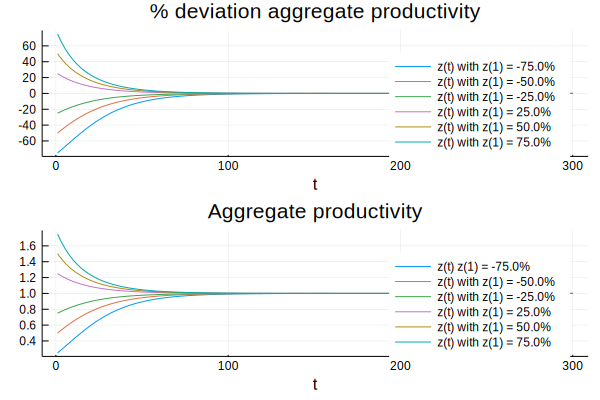

In [15]:
plot(p0,p1, fg_legend = :transparent, legend=:best, layout=(2,1))

*Notes: This graph shows the percentage deviation of aggregate productivity from its steady-state value (top panel) and aggregate productivity in level (bottom panel) for different initial shocks.*

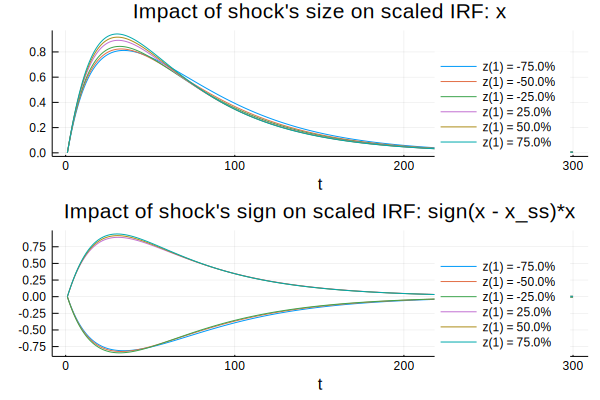

In [16]:
plot(p2,p3, fg_legend = :transparent, legend=:best, layout=(2,1))

*Notes: The top panel shows the scaled impulse response function of capital for different aggregate shocks. The bottom panel shows the scaled impulse response function of capital for different aggregate shocks, multiplied by the sign of the aggregate shock.*

### II.D. Out-of-steady-state dynamics

In [17]:
max_t = 2000
shocks_t = rand(Normal(0,0.005), max_t) # Series of aggregate shocks
# Let's generate a path for the aggregate shock
z_path = ones(max_t)
z_path[1] = z_ss

# Evolution of aggregate productivity in level:
for t_index=2:max_t 
    z_path[t_index] = z_path[t_index-1]^p.rho + shocks_t[t_index]
end

# Calculation of GenBKM path:
XT_GenBKM = zeros(max_t);# Initialization
@time GenBKM_path!(XT_GenBKM, max_t, x_mit_scaled_sigma, z_path./z_ss .- 1.0, array_sigma)

  0.216868 seconds (1.06 M allocations: 50.236 MiB)


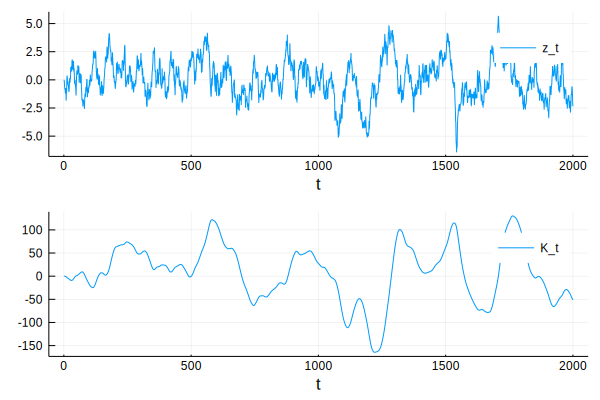

In [18]:
p1 = plot(100 .*(z_path./z_ss .- 1.0), label="z_t", xlabel="t")
p2 = plot(100 .*XT_GenBKM, label = "K_t", xlabel="t")
plot(p1,p2, fg_legend = :transparent, legend=:best, layout=(2,1))

*Notes: The top panel shows the percentage deviation of aggregate productivity from its steady-state value. The bottom panel shows the percentage deviation of capital from its steady-state value.*

## Conclusion

## References

* An excellent course on heterogeneous agent models: https://alisdairmckay.com/Notes/HetAgents/index.html
* More on the EGM method: https://julia.quantecon.org/dynamic_programming/egm_policy_iter.html
* [Car06] Christopher D Carroll. The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics Letters, 91(3):312–320, 2006.